### Predicting Football Results With the Poisson Distribution

http://www.pena.lt/y/2021/06/18/predicting-football-results-using-the-poisson-distribution/

In [4]:
import pandas as pd

#df = pd.read_csv("https://www.football-data.co.uk/mmz4281/1718/E0.csv")
df = pd.read_csv('./data/E0.csv')
df[["Date", "HomeTeam", "AwayTeam", "FTHG", "FTAG"]].head()

,Date,HomeTeam,AwayTeam,FTHG,FTAG
0,11/08/2017,Arsenal,Leicester,4,3
1,12/08/2017,Brighton,Man City,0,2
2,12/08/2017,Chelsea,Burnley,2,3
3,12/08/2017,Crystal Palace,Huddersfield,0,3
4,12/08/2017,Everton,Stoke,1,0


In [5]:
df[["FTHG", "FTAG"]].mean()

FTHG    1.531579
FTAG    1.147368
dtype: float64

Text(0.5, 1.0, 'Number of Goals Scored Per Match')

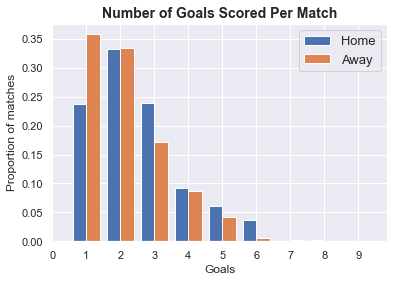

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

max_goals = 10
plt.hist(
    df[["FTHG", "FTAG"]].values, range(max_goals), label=["Home", "Away"], density=True
)
plt.xticks([i - 0.5 for i in range(max_goals)], [i for i in range(max_goals)])
plt.xlabel("Goals")
plt.ylabel("Proportion of matches")
plt.legend(loc="upper right", fontsize=13)
plt.title("Number of Goals Scored Per Match", size=14, fontweight="bold")

Text(0.5, 1.0, 'Number of Goals Scored Per Match')

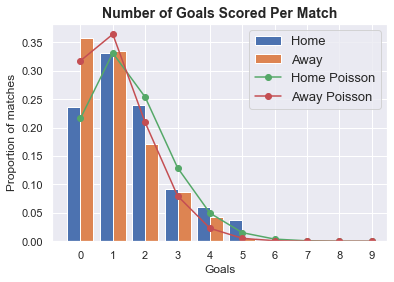

In [7]:
import numpy as np
from scipy.stats import poisson

home_poisson = poisson.pmf(range(10), df["FTHG"].mean())
away_poisson = poisson.pmf(range(10), df["FTAG"].mean())

max_goals = 10
plt.hist(
    df[["FTHG", "FTAG"]].values, range(max_goals), label=["Home", "Away"], density=True
)

plt.plot(
    [i - 0.5 for i in range(1, max_goals + 1)],
    home_poisson,
    linestyle="-",
    marker="o",
    label="Home Poisson",
)

plt.plot(
    [i - 0.5 for i in range(1, max_goals + 1)],
    away_poisson,
    linestyle="-",
    marker="o",
    label="Away Poisson",
)


plt.xticks([i - 0.5 for i in range(1, max_goals + 1)], [i for i in range(max_goals)])
plt.xlabel("Goals")
plt.ylabel("Proportion of matches")
plt.legend(loc="upper right", fontsize=13)
plt.title("Number of Goals Scored Per Match", size=14, fontweight="bold")

In [8]:
def log_likelihood(
    goals_home_observed,
    goals_away_observed,
    home_attack,
    home_defence,
    away_attack,
    away_defence,
    home_advantage,
):
    goal_expectation_home = np.exp(home_attack + away_defence + home_advantage)
    goal_expectation_away = np.exp(away_attack + home_defence)

    if goal_expectation_home < 0 or goal_expectation_away < 0:
        return 10000    

    home_llk = poisson.pmf(goals_home_observed, goal_expectation_home)
    away_llk = poisson.pmf(goals_away_observed, goal_expectation_away)

    log_llk = np.log(home_llk) + np.log(away_llk)

    return -log_llk

In [9]:
from scipy.optimize import minimize


def fit_poisson_model():
    teams = np.sort(np.unique(np.concatenate([df["HomeTeam"], df["AwayTeam"]])))
    n_teams = len(teams)

    params = np.concatenate(
        (
            np.random.uniform(0.5, 1.5, (n_teams)),  # attack strength
            np.random.uniform(0, -1, (n_teams)),  # defence strength
            [0.25],  # home advantage
        )
    )

    def _fit(params, df, teams):
        attack_params = dict(zip(teams, params[:n_teams]))
        defence_params = dict(zip(teams, params[n_teams : (2 * n_teams)]))
        home_advantage = params[-1]

        llk = list()
        for idx, row in df.iterrows():
            tmp = log_likelihood(
                row["FTHG"],
                row["FTAG"],
                attack_params[row["HomeTeam"]],
                defence_params[row["HomeTeam"]],
                attack_params[row["AwayTeam"]],
                defence_params[row["AwayTeam"]],
                home_advantage,
            )
            llk.append(tmp)

        return np.sum(llk)

    options = {
        "maxiter": 100,
        "disp": False,
    }

    constraints = [{"type": "eq", "fun": lambda x: sum(x[:n_teams]) - n_teams}]

    res = minimize(
        _fit,
        params,
        args=(df, teams),
        constraints=constraints,
        options=options,
    )

    model_params = dict(
        zip(
            ["attack_" + team for team in teams]
            + ["defence_" + team for team in teams]
            + ["home_adv"],
            res["x"],
        )
    )

    return model_params

model_params = fit_poisson_model()

/var/folders/mt/_c41mk5d48d02v2zcb5lld2h0000gn/T/ipykernel_22360/2836897768.py:19: RuntimeWarning: divide by zero encountered in log
  log_llk = np.log(home_llk) + np.log(away_llk)


In [8]:
from pprint import pprint

pprint(model_params)

{'attack_Arsenal': 1.4472960959077086,
 'attack_Bournemouth': 0.9586577503781972,
 'attack_Brighton': 0.6704406085481511,
 'attack_Burnley': 0.7124428177976605,
 'attack_Chelsea': 1.2560827083499768,
 'attack_Crystal Palace': 0.9524104053054706,
 'attack_Everton': 0.9329955722763397,
 'attack_Huddersfield': 0.4800241491879954,
 'attack_Leicester': 1.1770280182883157,
 'attack_Liverpool': 1.5606845805860983,
 'attack_Man City': 1.782351240120223,
 'attack_Man United': 1.3383155745789959,
 'attack_Newcastle': 0.8007493332896695,
 'attack_Southampton': 0.7572207203202753,
 'attack_Stoke': 0.7139463342172566,
 'attack_Swansea': 0.4779829985899056,
 'attack_Tottenham': 1.4314083146897396,
 'attack_Watford': 0.9392522715838968,
 'attack_West Brom': 0.5799415050731347,
 'attack_West Ham': 1.030769000910988,
 'defence_Arsenal': -0.9046205863665658,
 'defence_Bournemouth': -0.755566328448959,
 'defence_Brighton': -0.8891312122681508,
 'defence_Burnley': -1.2130522217733017,
 'defence_Chelsea': 

In [10]:
def predict(home_team, away_team, params, max_goals=10):
    home_attack = params["attack_" + home_team]
    home_defence = params["defence_" + home_team]
    away_attack = params["attack_" + away_team]
    away_defence = params["defence_" + away_team]
    home_advantage = params["home_adv"]

    home_goal_expectation = np.exp(home_attack + away_defence + home_advantage)
    away_goal_expectation = np.exp(away_attack + home_defence)

    home_probs = poisson.pmf(list(range(max_goals + 1)), home_goal_expectation)
    away_probs = poisson.pmf(range(max_goals + 1), away_goal_expectation)

    probability_matrix = np.outer(home_probs, away_probs)

    return probability_matrix

In [11]:
probs = predict("Man City", "Stoke", model_params, 4)
pprint(probs)

NameError: name 'pprint' is not defined

In [ ]:
# draw
np.sum(np.diag(probs))

In [ ]:
# home win
np.sum(np.tril(probs, -1))

In [ ]:
# away win
np.sum(np.triu(probs, 1))

In [1]:
import penaltyblog as pb

ModuleNotFoundError: No module named 'penaltyblog'

In [2]:
df = pb.footballdata.fetch_data("England", 2017, 0)
df[["Date", "HomeTeam", "AwayTeam", "FTHG", "FTAG"]].head()

pois = pb.poisson.PoissonGoalsModel(df["FTHG"], df["FTAG"], df["HomeTeam"], df["AwayTeam"])
pois.fit()
probs = pois.predict("Man City", "Man United")
print(probs.home_draw_away)

NameError: name 'pb' is not defined